In [1]:
%config Completer.use_jedi = False

In [2]:
from time import time
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [3]:
from WGAN import WGAN, WGAN_GP

## WD

<img src="pics/WD.jpg" width=800 height=800 />

In [23]:
p = np.array([3,2,1,4])
pi = np.array([1,2,4,3])

p = p / p.sum()
pi = pi / pi.sum()

pi = p.copy()

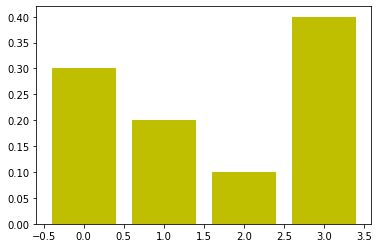

<BarContainer object of 4 artists>

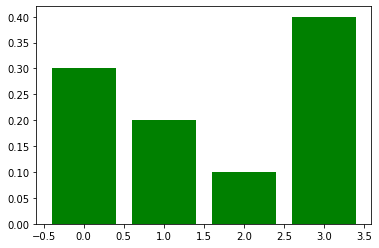

In [24]:
plt.bar(range(4), p, color='y')
plt.show()
plt.bar(range(4), pi, color='g')

In [33]:
def gamma(x,y):
    if x==y:
        return p[x]#*pi[y]
    else:
        return 0

In [34]:
X = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        X[i,j] = gamma(i,j)

In [35]:
X

array([[0.3, 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. ],
       [0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0.4]])

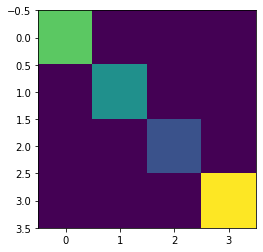

In [36]:
plt.imshow(X)

In [11]:
X.sum()

1.0

In [12]:
X.sum(axis=1)

array([0.3, 0.2, 0.1, 0.4])

In [15]:
p

array([0.3, 0.2, 0.1, 0.4])

In [13]:
X.sum(axis=0)

array([0.1, 0.2, 0.4, 0.3])

In [16]:
pi

array([0.1, 0.2, 0.4, 0.3])

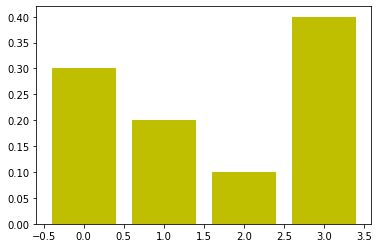

0 0 0.03


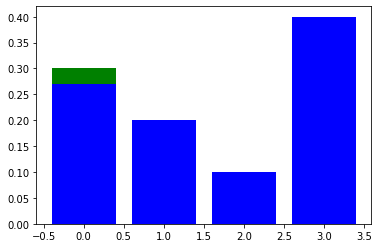

0 1 0.06


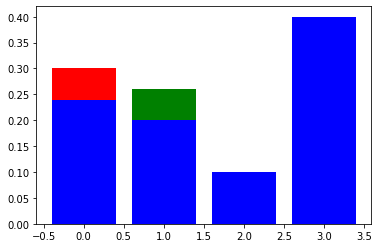

0 2 0.12


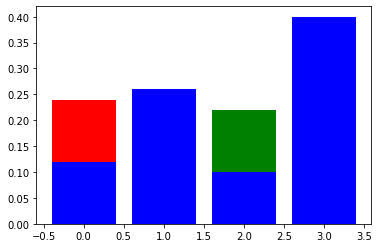

0 3 0.09


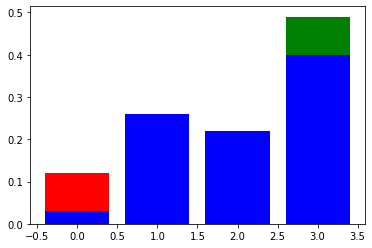

1 0 0.020000000000000004


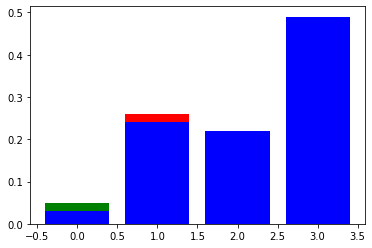

1 1 0.04000000000000001


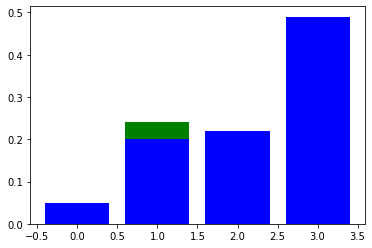

1 2 0.08000000000000002


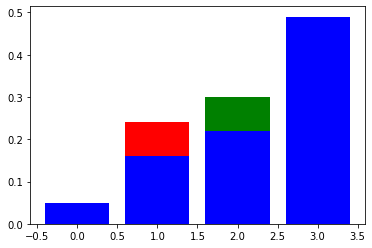

1 3 0.06


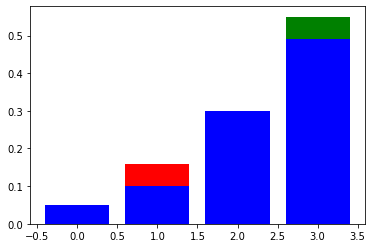

2 0 0.010000000000000002


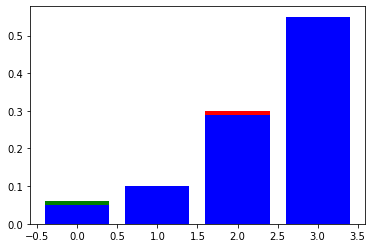

2 1 0.020000000000000004


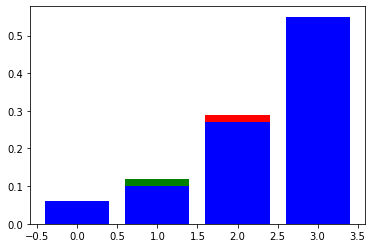

2 2 0.04000000000000001


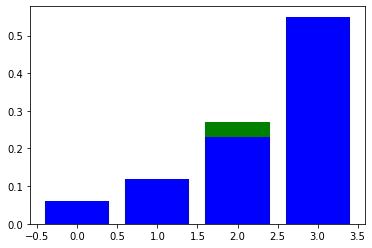

2 3 0.03


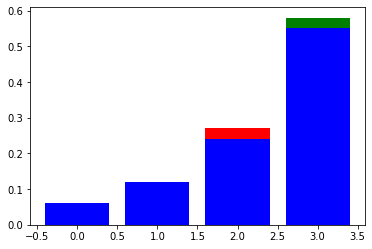

3 0 0.04000000000000001


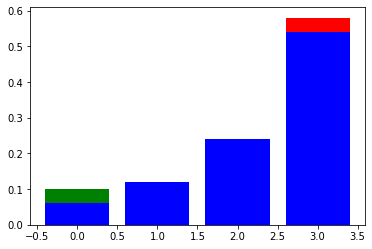

3 1 0.08000000000000002


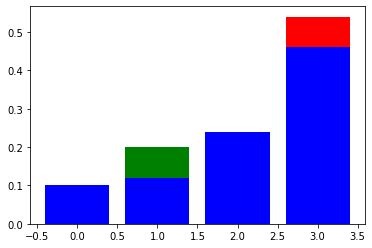

3 2 0.16000000000000003


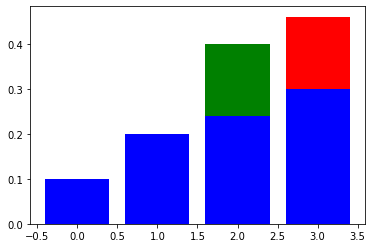

3 3 0.12


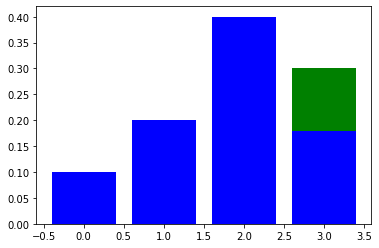

<BarContainer object of 4 artists>

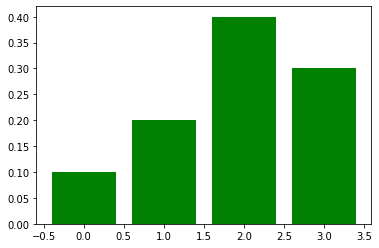

In [17]:
_p = p.copy()
_pi = pi.copy()

plt.bar(range(4), _p, color='y')
plt.show()

for i in range(4):
    for j in range(4):
        print(i,j, gamma(i,j))
        plt.bar(range(4), _p, color='r')
        _p[i] -= gamma(i,j)
        __p = _p.copy()
        _p[j] += gamma(i,j)
        plt.bar(range(4), _p, color='g')
        plt.bar(range(4), __p, color='b')
        plt.show()
        
plt.bar(range(4), _pi, color='g')

In [19]:
_p

array([0.1, 0.2, 0.4, 0.3])

In [20]:
_pi

array([0.1, 0.2, 0.4, 0.3])

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [37]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

In [38]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

In [39]:
def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()
    
    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

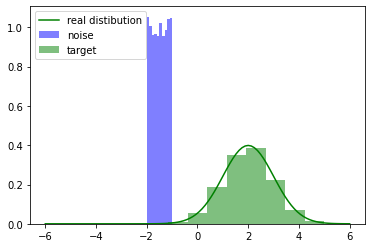

In [40]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [41]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        # your code here
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.optim_G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        # your code here
        # use self.target_ones
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.optim_D.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # you code here
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # you code here
        
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [42]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, np.clip(gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), a_min=-1, a_max=1), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

In [43]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

In [44]:
epochs = 50
batches = 100

Epoch 1/50 (0s): G=0.903, Dr=0.496, Df=0.545


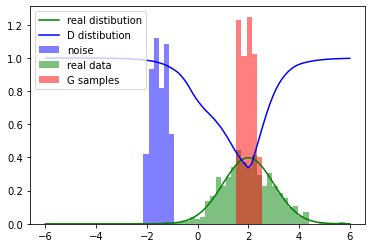

Epoch 2/50 (0s): G=1.002, Dr=0.570, Df=0.482


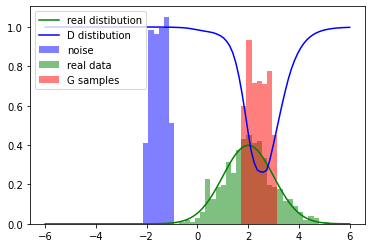

Epoch 3/50 (1s): G=0.994, Dr=0.585, Df=0.491


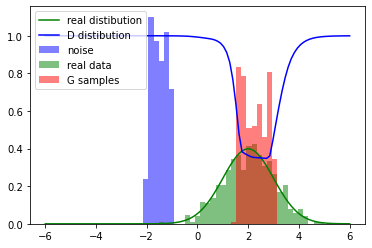

Epoch 4/50 (2s): G=0.918, Dr=0.604, Df=0.526


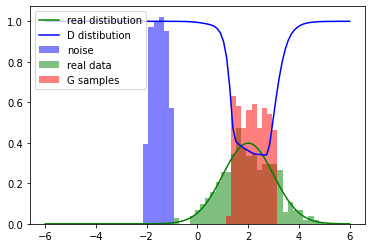

Epoch 5/50 (3s): G=0.876, Dr=0.625, Df=0.553


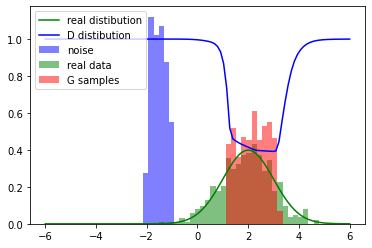

Epoch 6/50 (3s): G=0.838, Dr=0.642, Df=0.581


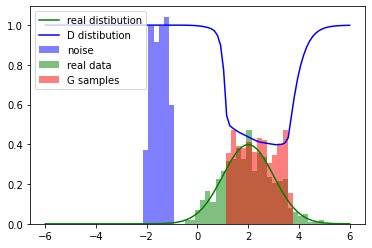

Epoch 7/50 (4s): G=0.810, Dr=0.646, Df=0.606


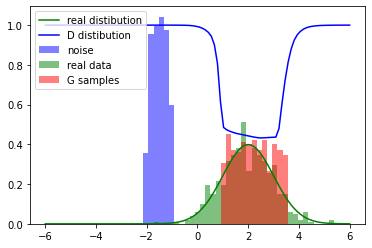

Epoch 8/50 (5s): G=0.775, Dr=0.660, Df=0.630


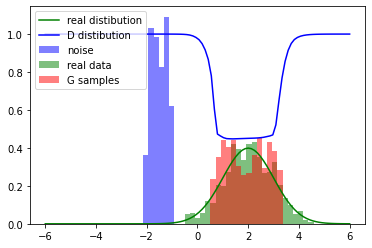

Epoch 9/50 (6s): G=0.758, Dr=0.669, Df=0.642


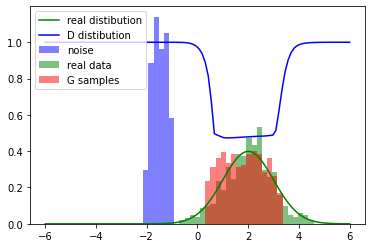

Epoch 10/50 (6s): G=0.754, Dr=0.679, Df=0.648


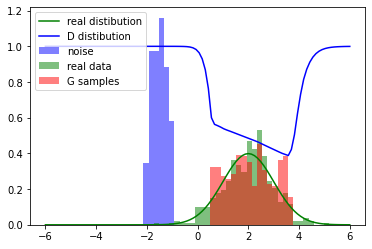

Epoch 11/50 (7s): G=0.730, Dr=0.673, Df=0.669


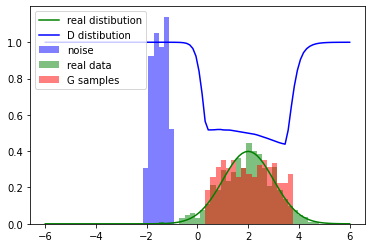

Epoch 12/50 (8s): G=0.723, Dr=0.675, Df=0.670


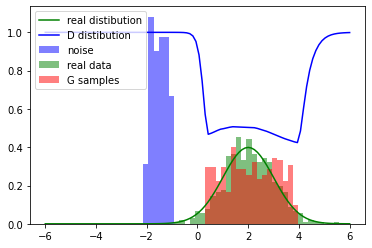

Epoch 13/50 (9s): G=0.737, Dr=0.672, Df=0.661


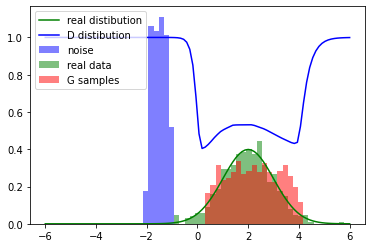

Epoch 14/50 (10s): G=0.741, Dr=0.672, Df=0.661


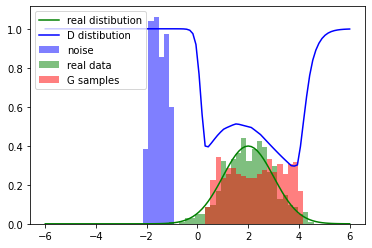

Epoch 15/50 (10s): G=0.748, Dr=0.660, Df=0.658


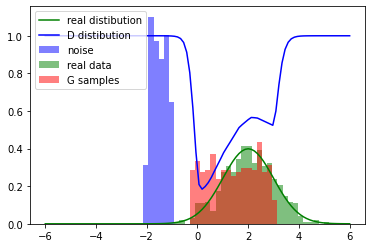

Epoch 16/50 (11s): G=0.799, Dr=0.671, Df=0.648


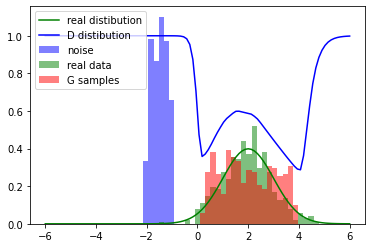

Epoch 17/50 (12s): G=0.760, Dr=0.666, Df=0.663


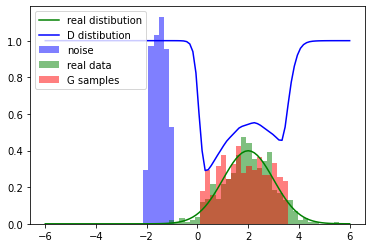

Epoch 18/50 (12s): G=0.766, Dr=0.668, Df=0.652


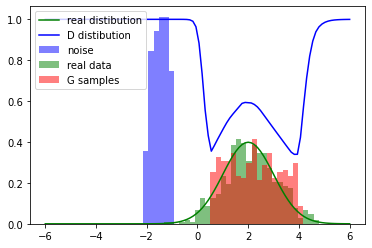

Epoch 19/50 (13s): G=0.758, Dr=0.667, Df=0.660


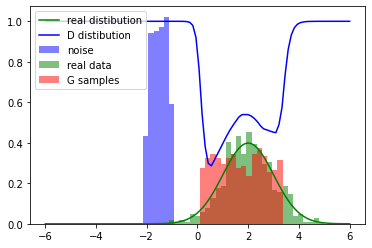

Epoch 20/50 (13s): G=0.779, Dr=0.666, Df=0.648


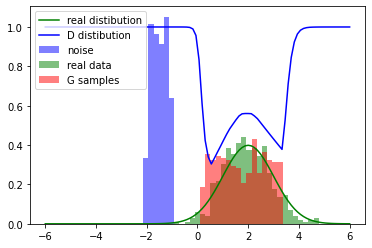

Epoch 21/50 (14s): G=0.772, Dr=0.668, Df=0.654


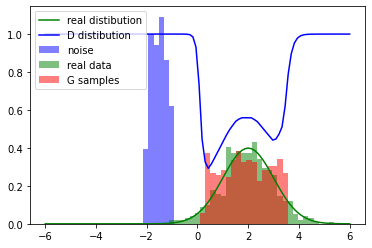

Epoch 22/50 (15s): G=0.766, Dr=0.671, Df=0.658


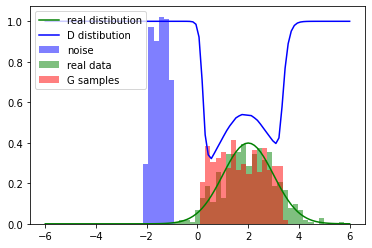

Epoch 23/50 (15s): G=0.770, Dr=0.671, Df=0.654


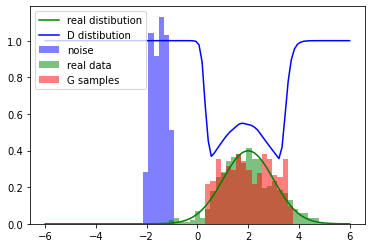

Epoch 24/50 (16s): G=0.797, Dr=0.669, Df=0.663


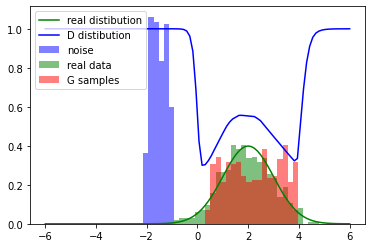

Epoch 25/50 (16s): G=0.755, Dr=0.675, Df=0.660


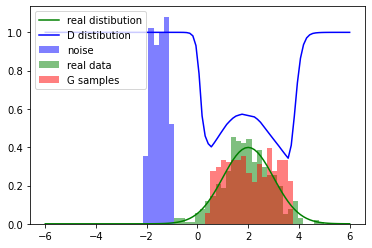

Epoch 26/50 (17s): G=0.760, Dr=0.665, Df=0.654


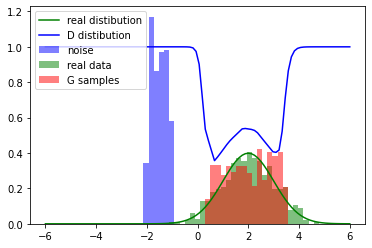

Epoch 27/50 (18s): G=0.764, Dr=0.666, Df=0.652


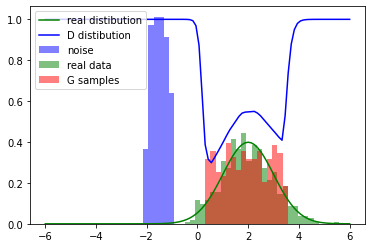

Epoch 28/50 (18s): G=0.785, Dr=0.665, Df=0.648


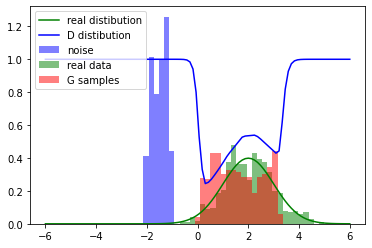

Epoch 29/50 (19s): G=0.771, Dr=0.672, Df=0.649


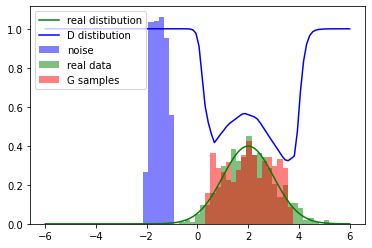

Epoch 30/50 (19s): G=0.763, Dr=0.670, Df=0.655


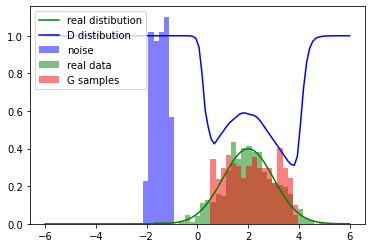

Epoch 31/50 (20s): G=0.766, Dr=0.662, Df=0.649


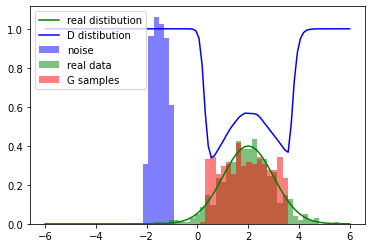

Epoch 32/50 (21s): G=0.797, Dr=0.662, Df=0.645


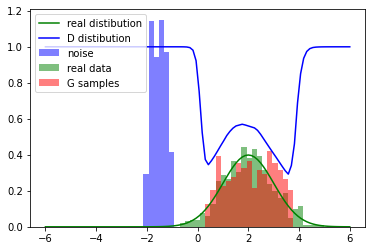

Epoch 33/50 (21s): G=0.763, Dr=0.664, Df=0.654


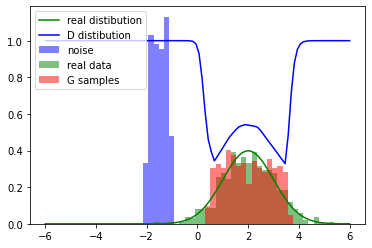

Epoch 34/50 (22s): G=0.783, Dr=0.664, Df=0.645


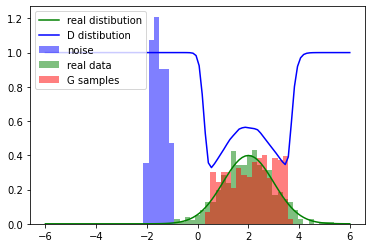

Epoch 35/50 (22s): G=0.767, Dr=0.666, Df=0.655


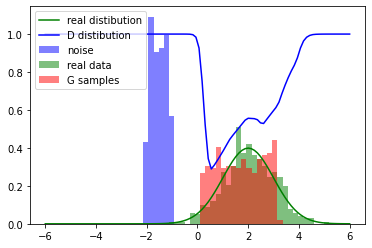

Epoch 36/50 (23s): G=0.768, Dr=0.675, Df=0.652


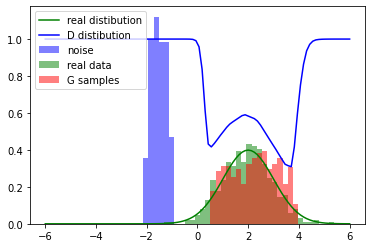

Epoch 37/50 (24s): G=0.768, Dr=0.661, Df=0.646


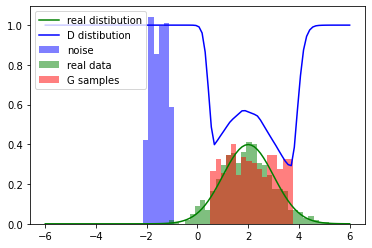

Epoch 38/50 (24s): G=0.802, Dr=0.656, Df=0.642


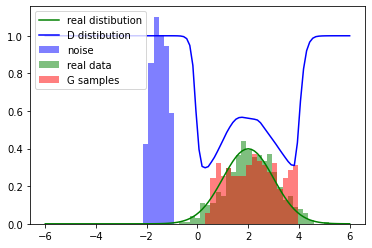

Epoch 39/50 (25s): G=0.760, Dr=0.676, Df=0.661


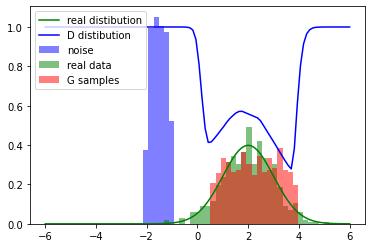

Epoch 40/50 (25s): G=0.767, Dr=0.664, Df=0.651


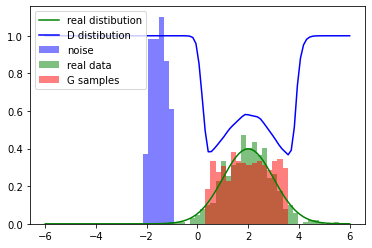

Epoch 41/50 (26s): G=0.772, Dr=0.666, Df=0.650


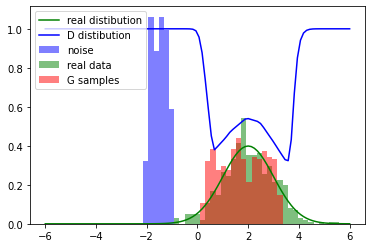

Epoch 42/50 (27s): G=0.808, Dr=0.662, Df=0.643


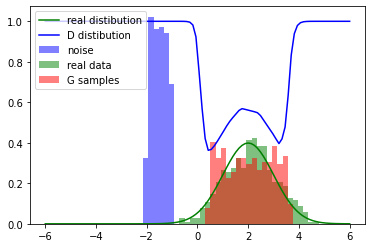

Epoch 43/50 (27s): G=0.769, Dr=0.667, Df=0.648


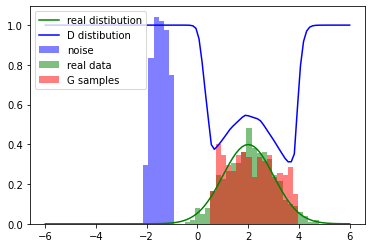

Epoch 44/50 (28s): G=0.768, Dr=0.667, Df=0.652


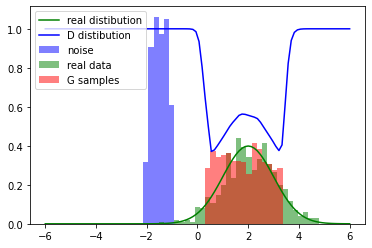

Epoch 45/50 (28s): G=0.781, Dr=0.660, Df=0.641


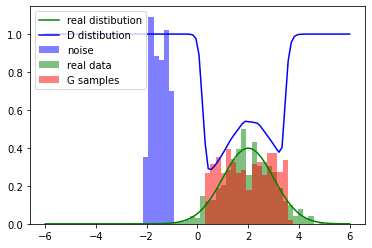

Epoch 46/50 (29s): G=0.782, Dr=0.667, Df=0.646


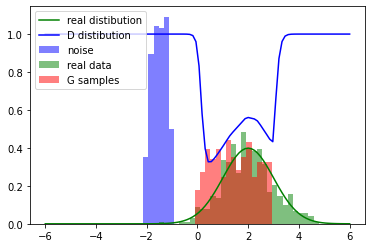

Epoch 47/50 (30s): G=0.803, Dr=0.665, Df=0.644


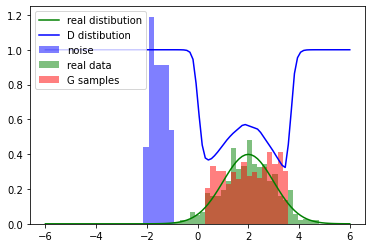

Epoch 48/50 (30s): G=0.776, Dr=0.671, Df=0.647


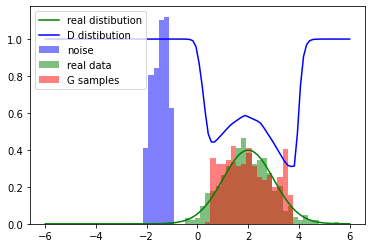

Epoch 49/50 (31s): G=0.771, Dr=0.660, Df=0.644


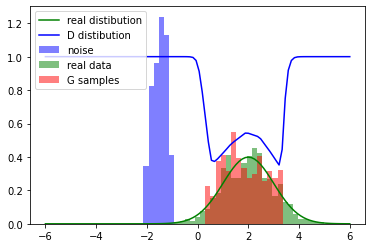

Epoch 50/50 (32s): G=0.773, Dr=0.664, Df=0.640


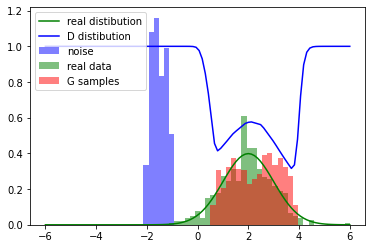

In [45]:
step_size = 30
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        #ldr_, ldf_ = gan.train_step_D()
        #if i%step_size == 0:
        #    print(i)
        #    print('D train step')
        #    visualize_GAN(gan)
        #lg_ = gan.train_step_G()
        #if i%step_size == 0:
        #    print('G train step')
        #    visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

## WGAN

<img src="pics/wgan_alg.jpg" width=800 height=800 />

<img src="pics/WGAN_obj.jpg" width=800 height=800 />

In [56]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN(G, D, noise_fn, data_fn, device='cpu', n_critic=5, clip_c=0.1)

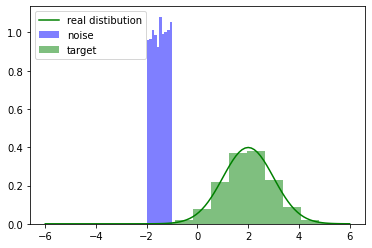

In [57]:
plot_gan_data(data_fn, noise_fn, data_pdf)

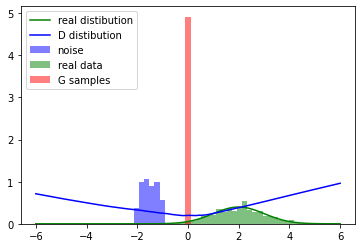

In [58]:
visualize_GAN(gan, data_pdf=data_pdf)

In [59]:
epochs = 50
batches = 100

Epoch 1/50 (0s): G=0.116, Dr=0.403, Df=0.116, WD=0.004


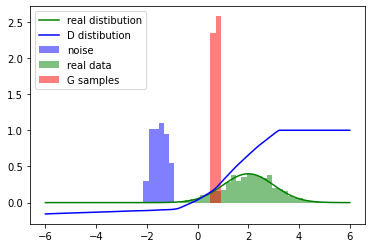

Epoch 2/50 (1s): G=0.339, Dr=0.809, Df=0.338, WD=0.005


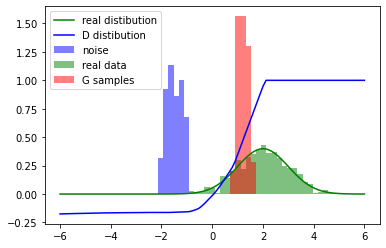

Epoch 3/50 (3s): G=0.634, Dr=1.026, Df=0.635, WD=0.002


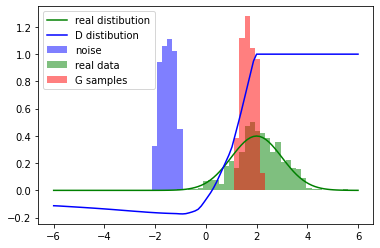

Epoch 4/50 (4s): G=0.915, Dr=1.025, Df=0.915, WD=0.000


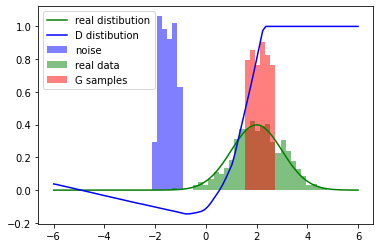

Epoch 5/50 (5s): G=0.394, Dr=0.341, Df=0.400, WD=-0.000


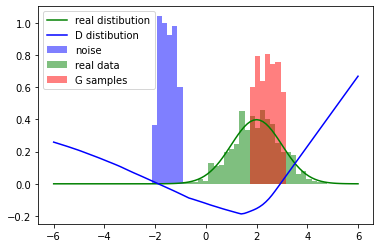

Epoch 6/50 (7s): G=-0.390, Dr=-0.334, Df=-0.387, WD=0.001


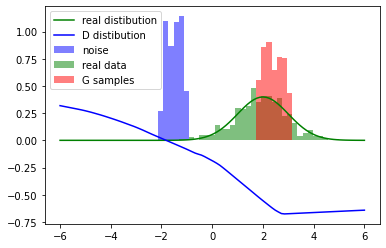

Epoch 7/50 (8s): G=-0.717, Dr=-0.617, Df=-0.715, WD=0.001


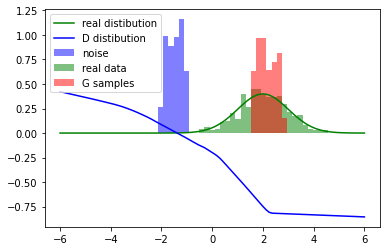

Epoch 8/50 (9s): G=-0.740, Dr=-0.642, Df=-0.741, WD=0.001


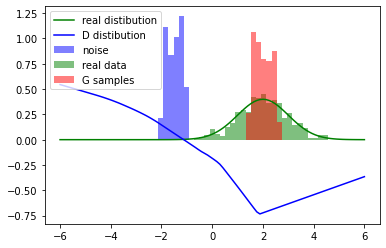

Epoch 9/50 (10s): G=-0.648, Dr=-0.540, Df=-0.648, WD=0.001


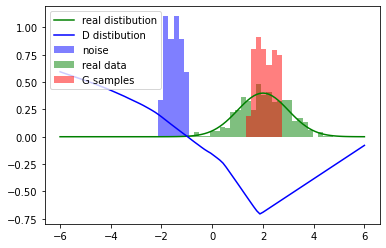

Epoch 10/50 (12s): G=-0.673, Dr=-0.553, Df=-0.673, WD=0.001


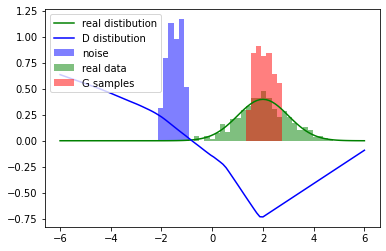

Epoch 11/50 (13s): G=-0.680, Dr=-0.554, Df=-0.678, WD=0.001


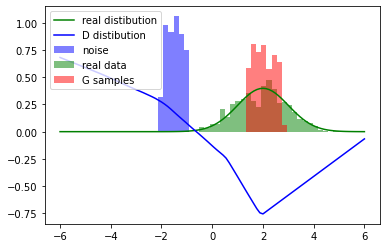

Epoch 12/50 (14s): G=-0.680, Dr=-0.553, Df=-0.681, WD=0.001


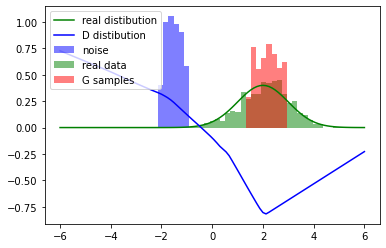

Epoch 13/50 (15s): G=-0.689, Dr=-0.561, Df=-0.689, WD=0.001


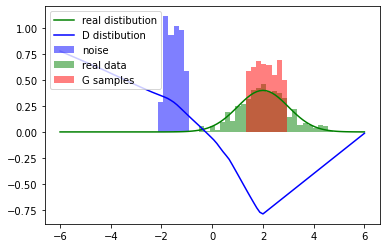

Epoch 14/50 (17s): G=-0.695, Dr=-0.563, Df=-0.695, WD=0.001


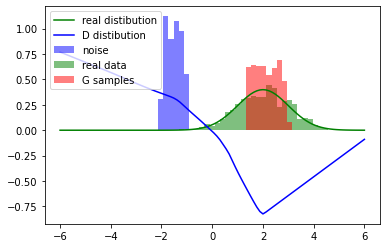

Epoch 15/50 (18s): G=-0.670, Dr=-0.534, Df=-0.667, WD=0.001


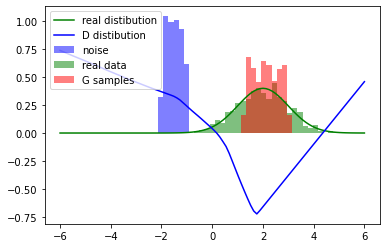

Epoch 16/50 (19s): G=-0.702, Dr=-0.570, Df=-0.703, WD=0.002


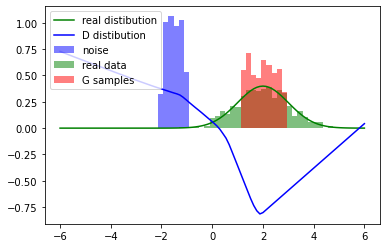

Epoch 17/50 (21s): G=-0.612, Dr=-0.486, Df=-0.612, WD=0.001


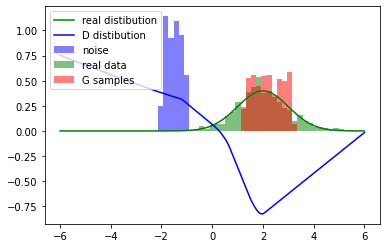

Epoch 18/50 (22s): G=-0.692, Dr=-0.571, Df=-0.692, WD=0.001


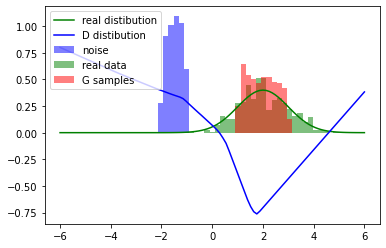

Epoch 19/50 (23s): G=-0.623, Dr=-0.511, Df=-0.623, WD=0.001


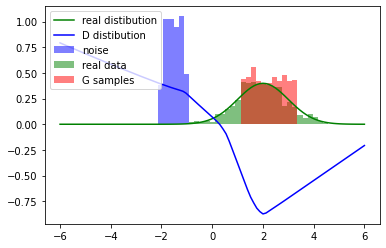

Epoch 20/50 (24s): G=-0.664, Dr=-0.571, Df=-0.669, WD=0.001


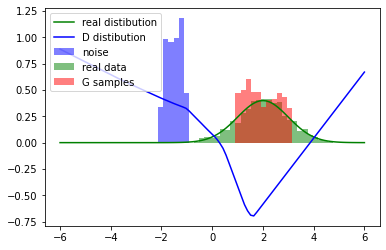

Epoch 21/50 (26s): G=-0.627, Dr=-0.540, Df=-0.624, WD=0.001


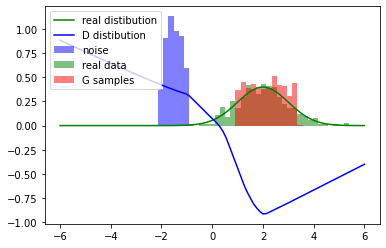

Epoch 22/50 (27s): G=-0.656, Dr=-0.579, Df=-0.657, WD=0.001


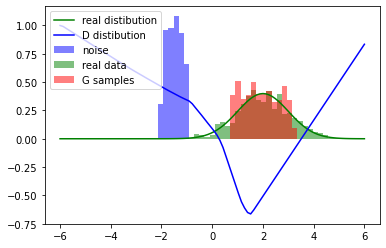

Epoch 23/50 (29s): G=-0.593, Dr=-0.524, Df=-0.590, WD=0.001


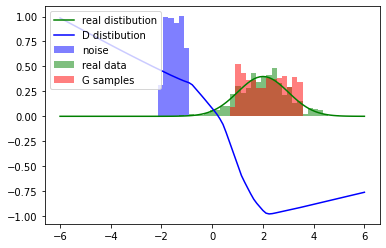

Epoch 24/50 (30s): G=-0.694, Dr=-0.642, Df=-0.693, WD=0.001


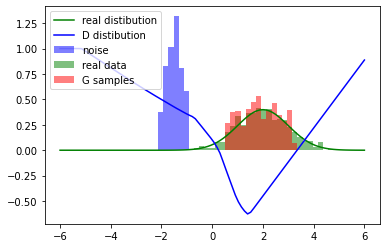

Epoch 25/50 (31s): G=-0.464, Dr=-0.412, Df=-0.456, WD=0.001


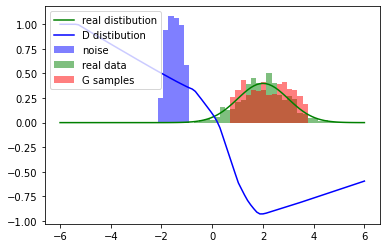

Epoch 26/50 (33s): G=-0.789, Dr=-0.754, Df=-0.792, WD=0.000


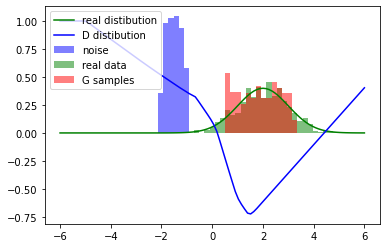

Epoch 27/50 (34s): G=-0.358, Dr=-0.322, Df=-0.351, WD=-0.000


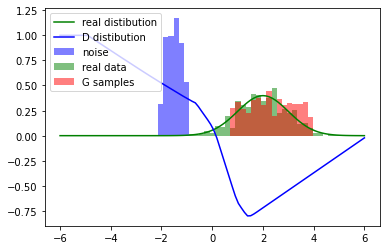

Epoch 28/50 (35s): G=-0.866, Dr=-0.838, Df=-0.872, WD=-0.000


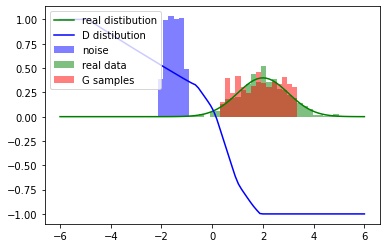

Epoch 29/50 (37s): G=-0.391, Dr=-0.367, Df=-0.394, WD=0.000


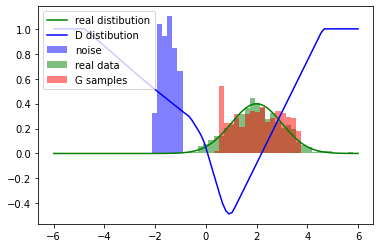

Epoch 30/50 (38s): G=-0.463, Dr=-0.449, Df=-0.457, WD=0.001


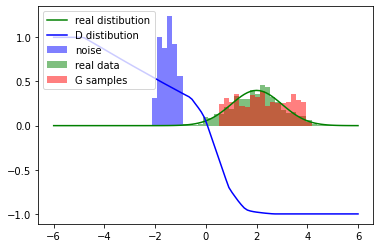

Epoch 31/50 (39s): G=-0.884, Dr=-0.881, Df=-0.886, WD=0.000


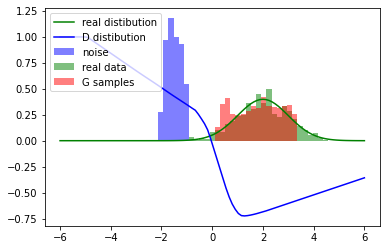

Epoch 32/50 (40s): G=-0.202, Dr=-0.186, Df=-0.207, WD=-0.000


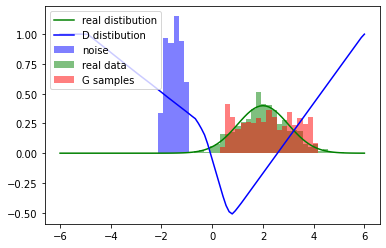

Epoch 33/50 (41s): G=-0.670, Dr=-0.654, Df=-0.671, WD=0.000


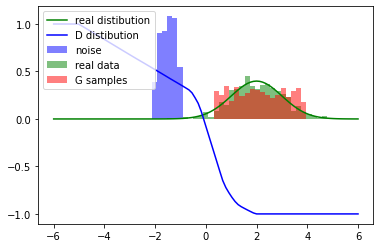

Epoch 34/50 (42s): G=-0.690, Dr=-0.694, Df=-0.697, WD=0.000


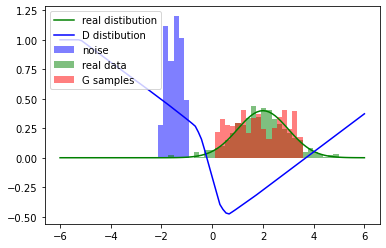

Epoch 35/50 (44s): G=-0.250, Dr=-0.238, Df=-0.248, WD=0.000


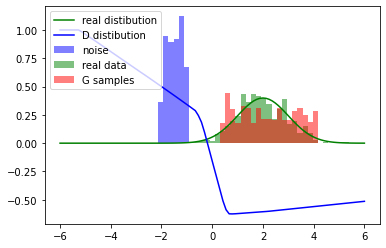

Epoch 36/50 (45s): G=-0.736, Dr=-0.726, Df=-0.741, WD=-0.000


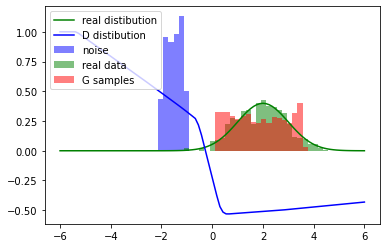

Epoch 37/50 (46s): G=-0.268, Dr=-0.257, Df=-0.268, WD=0.000


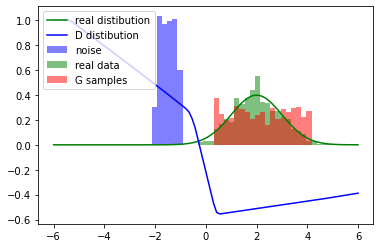

Epoch 38/50 (48s): G=-0.656, Dr=-0.644, Df=-0.657, WD=0.000


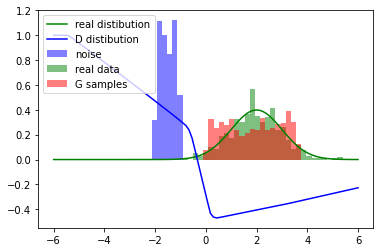

Epoch 39/50 (49s): G=-0.325, Dr=-0.309, Df=-0.320, WD=0.000


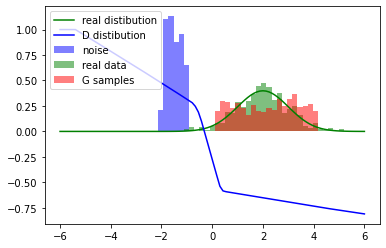

Epoch 40/50 (50s): G=-0.570, Dr=-0.558, Df=-0.569, WD=0.000


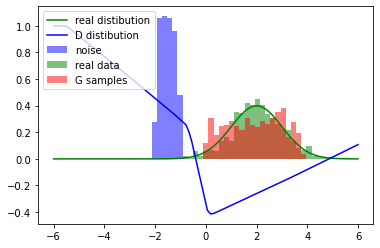

Epoch 41/50 (52s): G=-0.416, Dr=-0.401, Df=-0.411, WD=0.000


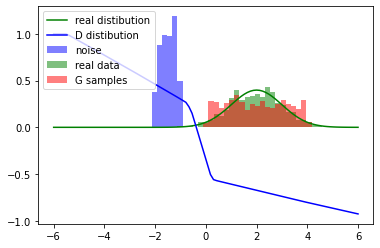

Epoch 42/50 (53s): G=-0.392, Dr=-0.389, Df=-0.396, WD=-0.000


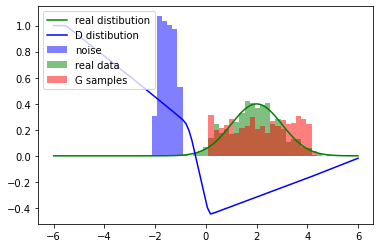

Epoch 43/50 (54s): G=-0.547, Dr=-0.538, Df=-0.547, WD=0.000


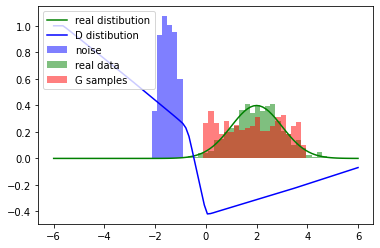

Epoch 44/50 (55s): G=-0.388, Dr=-0.377, Df=-0.386, WD=0.000


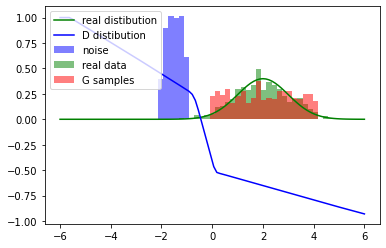

Epoch 45/50 (56s): G=-0.370, Dr=-0.364, Df=-0.369, WD=0.000


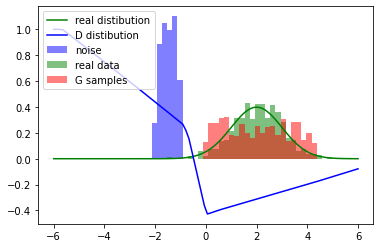

Epoch 46/50 (58s): G=-0.505, Dr=-0.499, Df=-0.505, WD=0.000


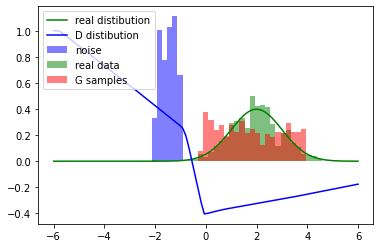

Epoch 47/50 (59s): G=-0.382, Dr=-0.373, Df=-0.380, WD=0.000


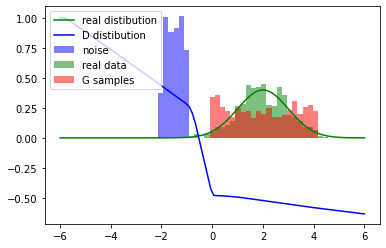

Epoch 48/50 (60s): G=-0.411, Dr=-0.403, Df=-0.409, WD=0.000


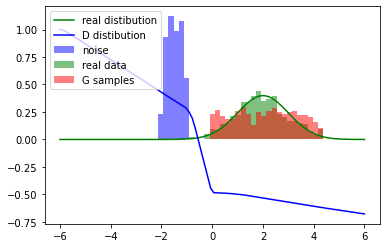

Epoch 49/50 (61s): G=-0.402, Dr=-0.394, Df=-0.402, WD=0.000


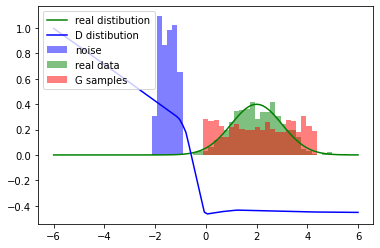

Epoch 50/50 (62s): G=-0.429, Dr=-0.419, Df=-0.429, WD=0.000


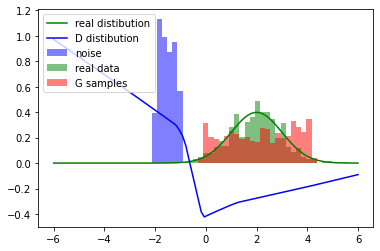

In [60]:
loss_g, loss_d_real, loss_d_fake, loss_WD = [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running = 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f},"
            f" WD={loss_WD[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break

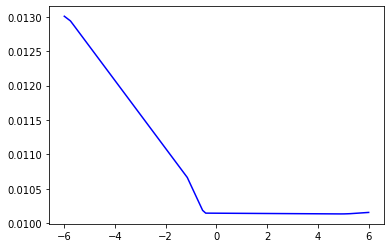

In [55]:
x = np.linspace(-6,6,100)
with torch.no_grad():
        plt.plot(x, np.clip(gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), a_min=-1, a_max=1), 'b', label='D distibution')

In [62]:
params = []
for param in gan.D.parameters():
    params.extend(param.detach().numpy().flatten())

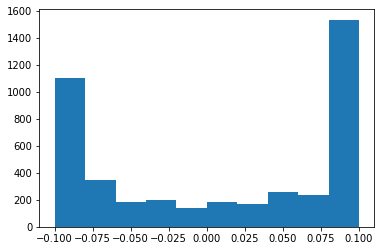

In [63]:
plt.hist(params);

In [48]:
######

In [49]:
mu1 = 3
mu2 = -3
k = 0.7

noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

def data_fn(x):
    a = mu1 + torch.randn((x, 1), device='cpu')
    b = mu2 + torch.randn((x, 1), device='cpu')
    mask = np.random.rand(x) < k
    mask = mask[:, None]
    samples = (a * mask + b * (1 - mask))
    
    return samples.float()

data_pdf = lambda X: k*norm.pdf(X-mu1)+(1-k)*norm.pdf(X-mu2)

In [ ]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [51]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN(G, D, noise_fn, data_fn, device='cpu', n_critic=5, clip_c=0.1)
loss_g, loss_d_real, loss_d_fake = [], [], []

In [52]:
epochs = 20
batches = 100

In [ ]:
loss_g, loss_d_real, loss_d_fake, loss_WD = [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running = 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f},"
            f" WD={loss_WD[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

## WGAN-GP

<img src="pics/WGAN-GP_theorem.jpg" width=800 height=800 />

<img src="pics/wgan-gp_alg.jpg" width=800 height=800 />

<img src="pics/WGAN-GP_obj.jpg" width=800 height=800 />

In [73]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN_GP(G, D, noise_fn, data_fn, device='cpu', n_critic=5, Lambda=1, lr_G=5e-5)

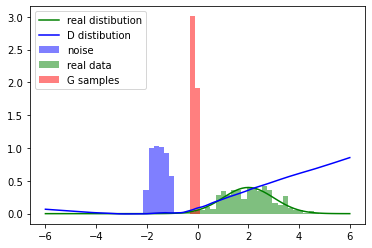

In [74]:
visualize_GAN(gan, data_pdf=data_pdf)

In [75]:
epochs = 50
batches = 100

In [77]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, np.clip(gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), a_min=-1, a_max=1), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

In [68]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

Epoch 1/50 (1s): G=-0.397, Dr=0.206, Df=-0.391 WD=0.005, GP=0.077


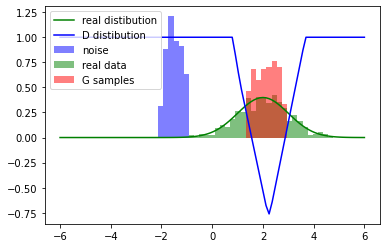

Epoch 2/50 (2s): G=-0.339, Dr=0.237, Df=-0.345 WD=0.007, GP=0.085


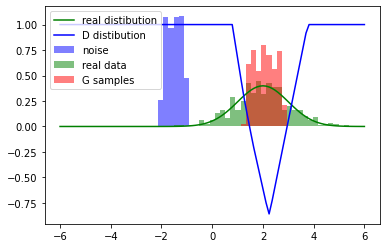

Epoch 3/50 (4s): G=-0.354, Dr=0.186, Df=-0.356 WD=0.005, GP=0.087


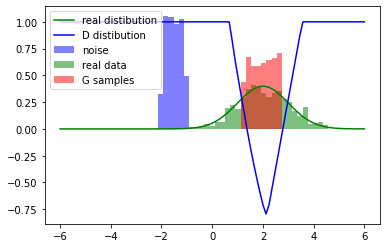

Epoch 4/50 (6s): G=-0.442, Dr=0.073, Df=-0.431 WD=0.006, GP=0.088


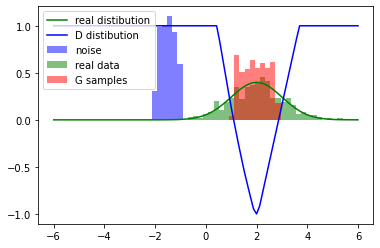

Epoch 5/50 (8s): G=-0.594, Dr=-0.144, Df=-0.582 WD=0.004, GP=0.061


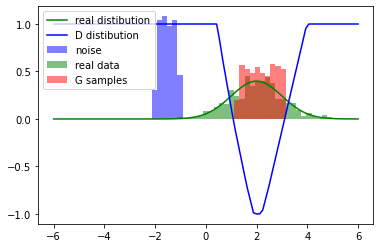

Epoch 6/50 (9s): G=-0.592, Dr=-0.175, Df=-0.607 WD=0.004, GP=0.089


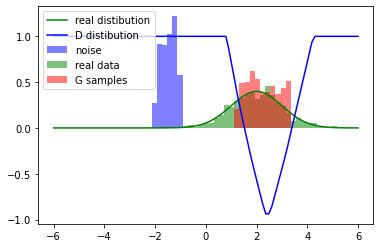

Epoch 7/50 (11s): G=-0.135, Dr=0.276, Df=-0.127 WD=0.002, GP=0.112


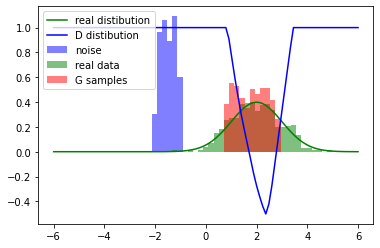

Epoch 8/50 (12s): G=-0.036, Dr=0.348, Df=-0.031 WD=0.005, GP=0.160


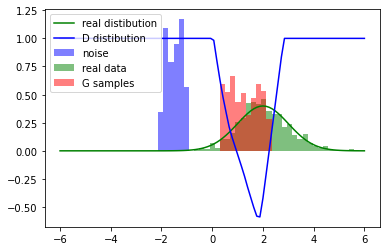

Epoch 9/50 (14s): G=-0.296, Dr=0.399, Df=-0.277 WD=0.007, GP=0.260


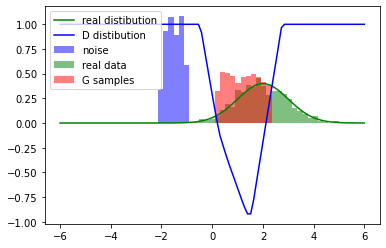

Epoch 10/50 (16s): G=-0.701, Dr=-0.222, Df=-0.686 WD=0.002, GP=0.126


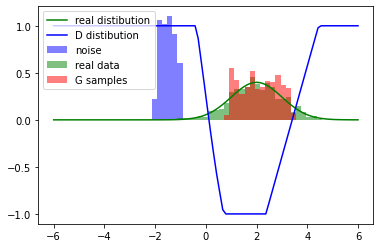

Epoch 11/50 (18s): G=-1.226, Dr=-1.203, Df=-1.213 WD=-0.001, GP=0.175


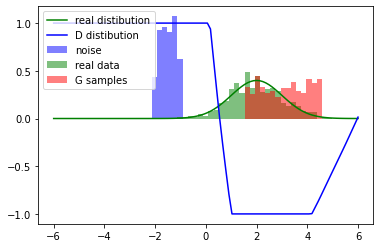

Epoch 12/50 (20s): G=-3.418, Dr=-2.492, Df=-3.385 WD=0.007, GP=0.597


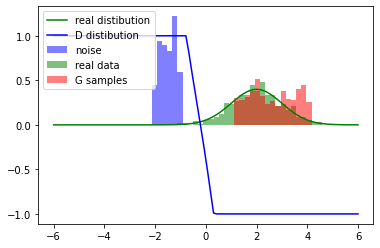

Epoch 13/50 (21s): G=-3.492, Dr=-3.430, Df=-3.485 WD=-0.005, GP=0.095


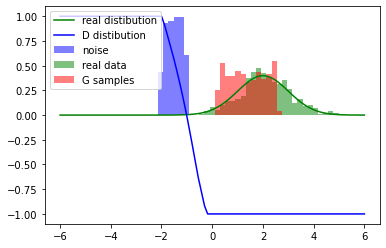

Epoch 14/50 (23s): G=-1.612, Dr=-1.456, Df=-1.619 WD=0.010, GP=0.280


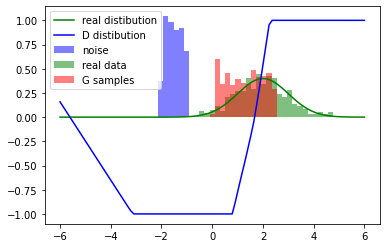

Epoch 15/50 (25s): G=-0.206, Dr=0.053, Df=-0.174 WD=-0.004, GP=0.076


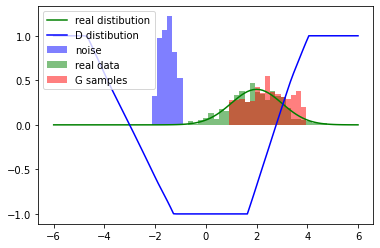

Epoch 16/50 (26s): G=-0.303, Dr=-0.728, Df=-0.299 WD=-0.005, GP=0.180


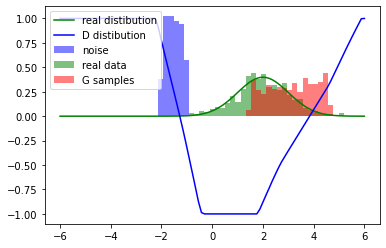

Epoch 17/50 (28s): G=-2.557, Dr=-2.135, Df=-2.528 WD=0.010, GP=0.392


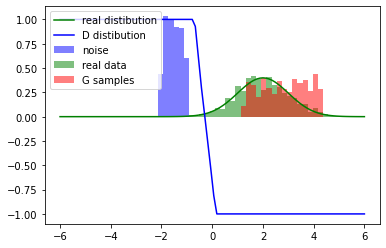

Epoch 18/50 (30s): G=-3.921, Dr=-3.596, Df=-3.916 WD=-0.002, GP=0.061


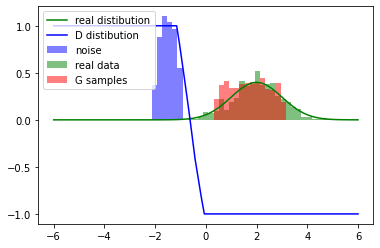

Epoch 19/50 (31s): G=-2.449, Dr=-2.808, Df=-2.428 WD=-0.004, GP=0.148


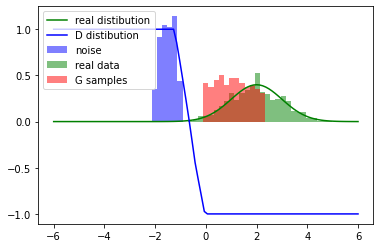

Epoch 20/50 (33s): G=-0.937, Dr=-0.448, Df=-0.945 WD=0.010, GP=0.333


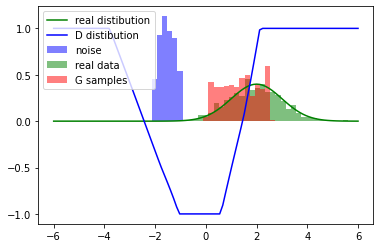

Epoch 21/50 (35s): G=-0.081, Dr=0.199, Df=-0.090 WD=-0.002, GP=0.056


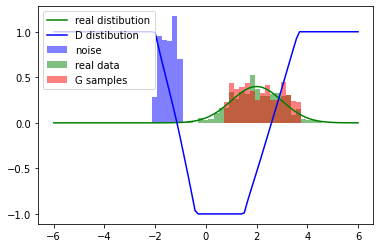

Epoch 22/50 (36s): G=-0.930, Dr=-1.066, Df=-0.910 WD=0.001, GP=0.218


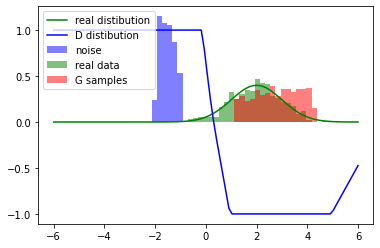

Epoch 23/50 (38s): G=-3.296, Dr=-2.892, Df=-3.296 WD=-0.000, GP=0.185


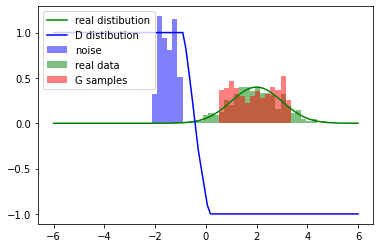

Epoch 24/50 (40s): G=-2.895, Dr=-3.148, Df=-2.884 WD=-0.005, GP=0.123


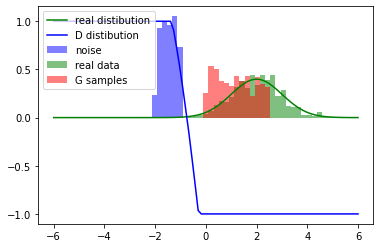

Epoch 25/50 (42s): G=-1.951, Dr=-2.205, Df=-1.970 WD=0.019, GP=0.289


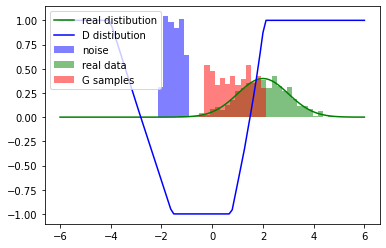

Epoch 26/50 (43s): G=-0.593, Dr=0.306, Df=-0.572 WD=0.001, GP=0.163


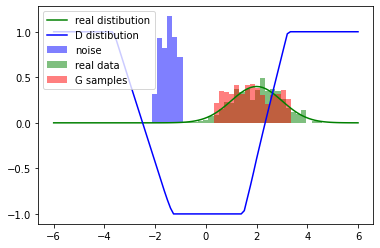

Epoch 27/50 (45s): G=-0.770, Dr=-0.915, Df=-0.758 WD=-0.004, GP=0.050


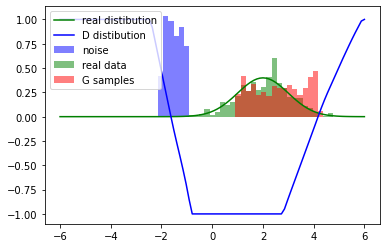

Epoch 28/50 (47s): G=-1.027, Dr=-1.439, Df=-1.025 WD=-0.005, GP=0.252


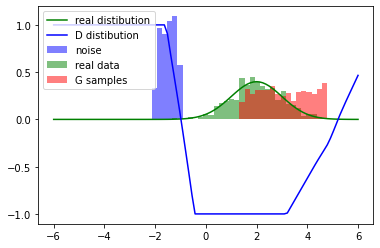

Epoch 29/50 (48s): G=-1.987, Dr=-1.830, Df=-1.956 WD=0.020, GP=0.414


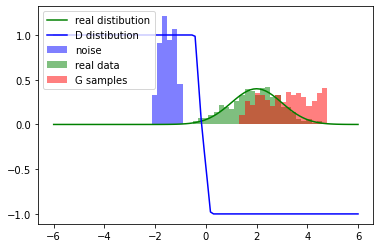

Epoch 30/50 (50s): G=-4.795, Dr=-4.072, Df=-4.835 WD=-0.000, GP=0.132


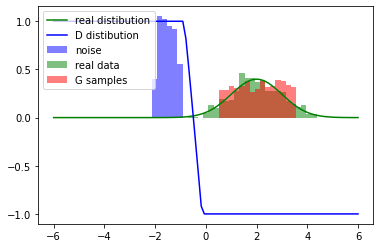

Epoch 31/50 (52s): G=-3.146, Dr=-3.384, Df=-3.165 WD=-0.004, GP=0.056


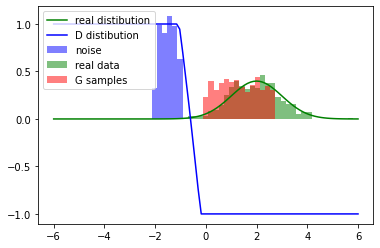

Epoch 32/50 (53s): G=-2.501, Dr=-2.913, Df=-2.491 WD=-0.004, GP=0.270


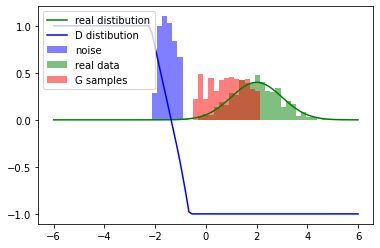

Epoch 33/50 (55s): G=-1.453, Dr=-0.545, Df=-1.452 WD=0.007, GP=0.276


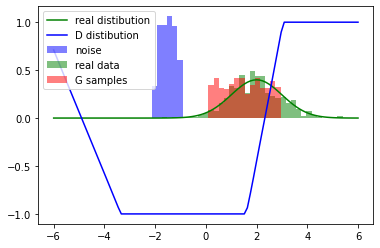

Epoch 34/50 (56s): G=-1.176, Dr=-1.035, Df=-1.149 WD=-0.002, GP=0.026


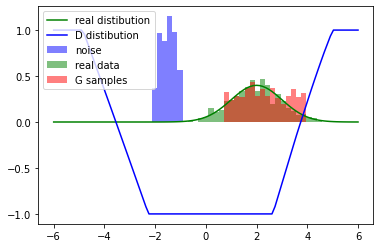

Epoch 35/50 (58s): G=-1.592, Dr=-1.961, Df=-1.617 WD=-0.004, GP=0.160


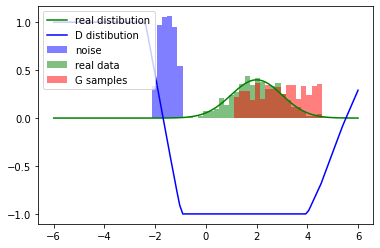

Epoch 36/50 (59s): G=-1.344, Dr=-1.673, Df=-1.348 WD=0.003, GP=0.394


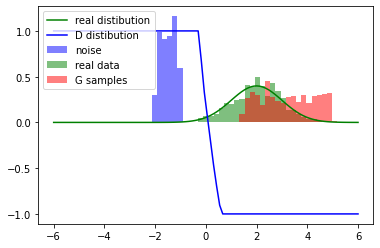

Epoch 37/50 (61s): G=-5.095, Dr=-4.014, Df=-5.032 WD=0.004, GP=0.302


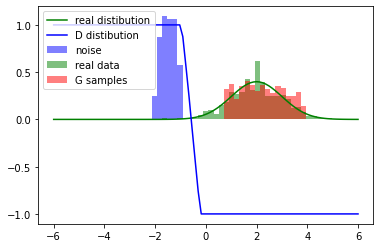

Epoch 38/50 (63s): G=-3.850, Dr=-3.870, Df=-3.836 WD=-0.004, GP=0.042


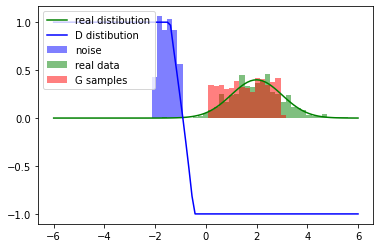

Epoch 39/50 (65s): G=-3.280, Dr=-3.683, Df=-3.286 WD=-0.005, GP=0.186


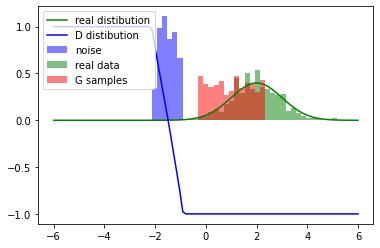

Epoch 40/50 (66s): G=-2.916, Dr=-2.654, Df=-2.902 WD=0.016, GP=0.351


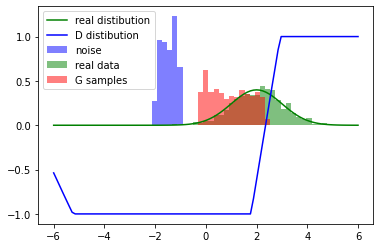

Epoch 41/50 (68s): G=-1.935, Dr=-1.249, Df=-1.915 WD=0.000, GP=0.104


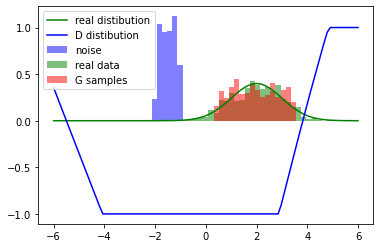

Epoch 42/50 (70s): G=-2.274, Dr=-2.484, Df=-2.275 WD=-0.003, GP=0.056


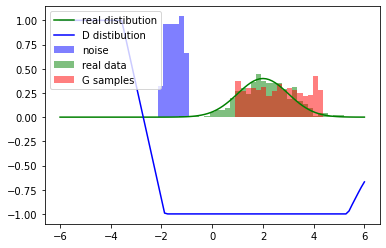

Epoch 43/50 (72s): G=-4.313, Dr=-4.006, Df=-4.298 WD=0.004, GP=0.284


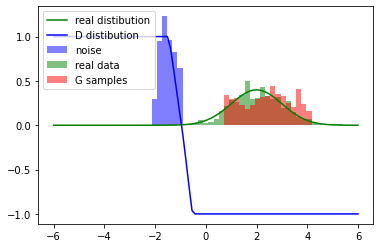

Epoch 44/50 (73s): G=-4.780, Dr=-4.728, Df=-4.765 WD=-0.003, GP=0.039


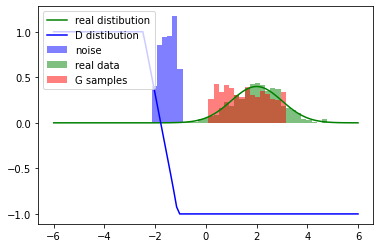

Epoch 45/50 (75s): G=-5.124, Dr=-5.505, Df=-5.123 WD=-0.005, GP=0.188


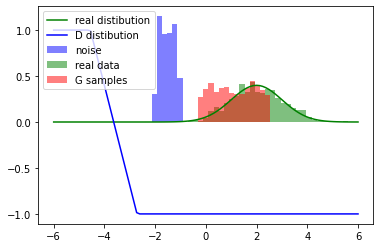

Epoch 46/50 (77s): G=-4.798, Dr=-5.267, Df=-4.802 WD=-0.004, GP=0.328


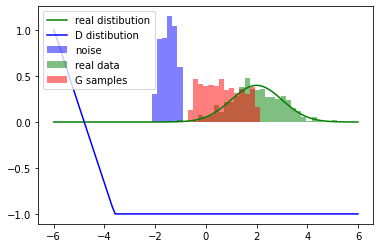

Epoch 47/50 (79s): G=-4.346, Dr=-3.878, Df=-4.339 WD=0.018, GP=0.458


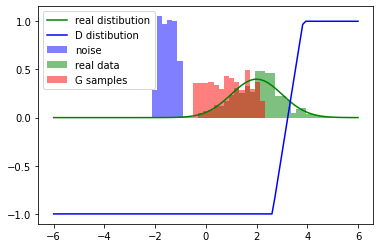

Epoch 48/50 (80s): G=-3.567, Dr=-2.714, Df=-3.547 WD=-0.001, GP=0.131


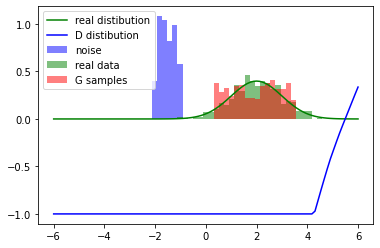

Epoch 49/50 (82s): G=-3.444, Dr=-3.648, Df=-3.469 WD=-0.004, GP=0.038


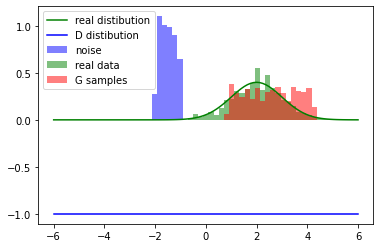

Epoch 50/50 (83s): G=-3.357, Dr=-3.825, Df=-3.375 WD=-0.005, GP=0.241


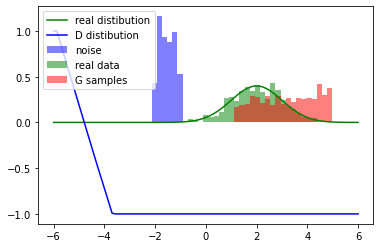

In [78]:
step_size = 30
loss_g, loss_d_real, loss_d_fake, loss_WD, loss_gp = [], [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running, loss_gp_running = 0, 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_, lgp_) = gan.train_step()
        #ldr_, ldf_ = gan.train_step_D()
        #if i%step_size == 0:
        #    print(i)
        #    print('D train step')
        #    visualize_GAN(gan)
        #lg_ = gan.train_step_G()
        #if i%step_size == 0:
        #    print('G train step')
        #    visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_gp_running += lgp_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_gp.append(loss_gp_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}"
          f" WD={loss_WD[-1]:.3f},"
          f" GP={loss_gp[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break

In [79]:
params = []
for param in gan.D.parameters():
    params.extend(param.detach().numpy().flatten())

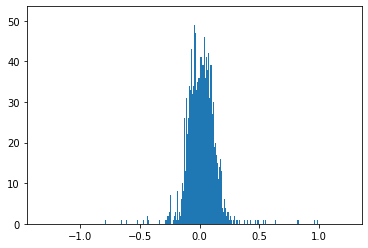

In [81]:
plt.hist(params, bins=1000);

In [82]:
mu1 = 3
mu2 = -3
k = 0.7

noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

def data_fn(x):
    a = mu1 + torch.randn((x, 1), device='cpu')
    b = mu2 + torch.randn((x, 1), device='cpu')
    mask = np.random.rand(x) < k
    mask = mask[:, None]
    samples = (a * mask + b * (1 - mask))
    
    return samples.float()

data_pdf = lambda X: k*norm.pdf(X-mu1)+(1-k)*norm.pdf(X-mu2)

In [83]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN_GP(G, D, noise_fn, data_fn, device='cpu', n_critic=3, Lambda=1, lr_D = 1e-5, lr_G = 2e-5)

In [85]:
epochs = 50
batches = 100

Epoch 1/50 (0s): G=1.001, Dr=1.944, Df=1.019 WD=0.011, GP=0.556


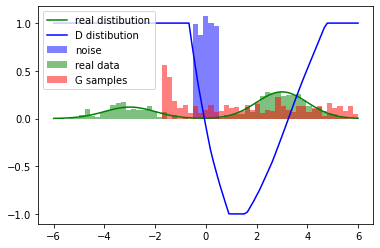

Epoch 2/50 (2s): G=1.046, Dr=1.886, Df=1.107 WD=0.008, GP=0.522


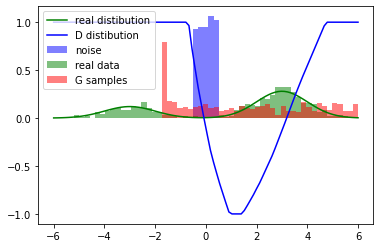

Epoch 3/50 (3s): G=1.076, Dr=1.833, Df=1.086 WD=0.008, GP=0.511


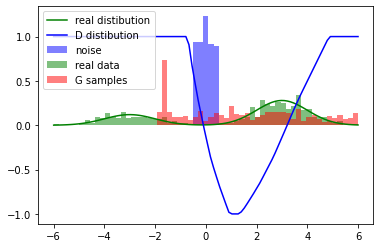

Epoch 4/50 (5s): G=1.092, Dr=1.761, Df=1.130 WD=0.009, GP=0.486


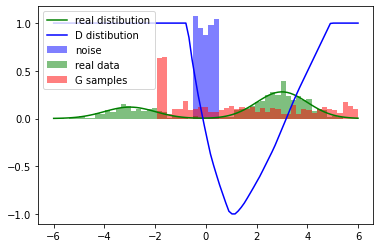

Epoch 5/50 (6s): G=1.094, Dr=1.755, Df=1.112 WD=0.002, GP=0.486


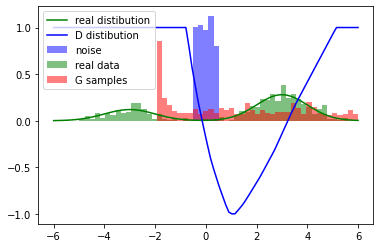

Epoch 6/50 (8s): G=1.073, Dr=1.702, Df=1.099 WD=0.002, GP=0.485


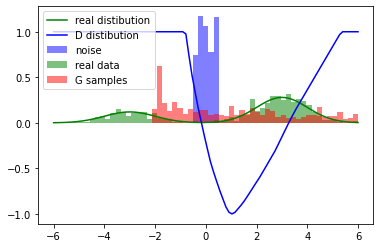

Epoch 7/50 (9s): G=1.084, Dr=1.573, Df=1.111 WD=0.004, GP=0.466


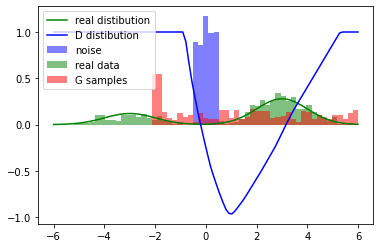

Epoch 8/50 (10s): G=1.156, Dr=1.597, Df=1.146 WD=0.007, GP=0.444


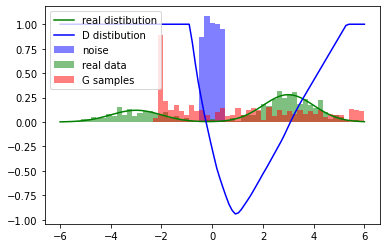

Epoch 9/50 (12s): G=1.226, Dr=1.567, Df=1.207 WD=0.006, GP=0.422


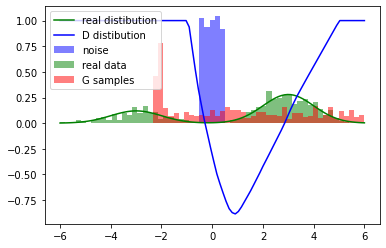

Epoch 10/50 (13s): G=1.260, Dr=1.552, Df=1.235 WD=0.007, GP=0.395


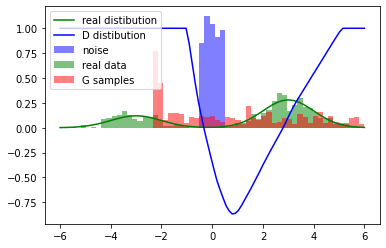

Epoch 11/50 (14s): G=1.257, Dr=1.480, Df=1.240 WD=-0.000, GP=0.382


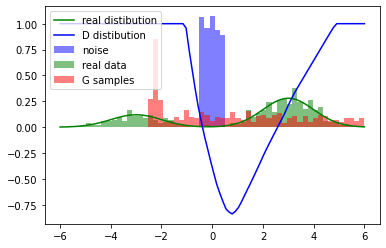

Epoch 12/50 (16s): G=1.251, Dr=1.438, Df=1.284 WD=-0.000, GP=0.352


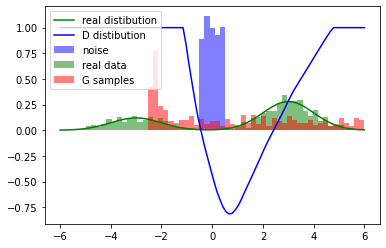

Epoch 13/50 (17s): G=1.274, Dr=1.455, Df=1.297 WD=0.003, GP=0.329


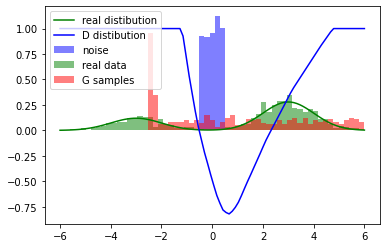

Epoch 14/50 (18s): G=1.252, Dr=1.382, Df=1.269 WD=0.001, GP=0.327


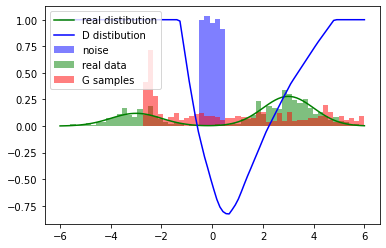

Epoch 15/50 (20s): G=1.258, Dr=1.305, Df=1.251 WD=0.001, GP=0.319


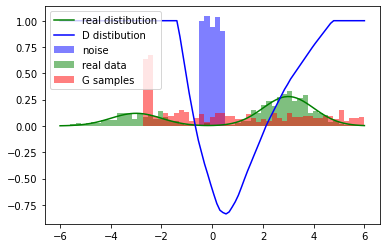

Epoch 16/50 (21s): G=1.183, Dr=1.225, Df=1.197 WD=-0.001, GP=0.316


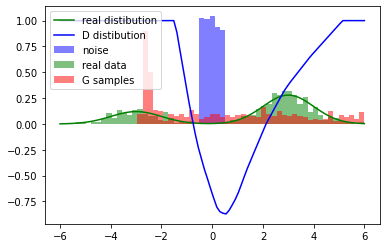

Epoch 17/50 (23s): G=1.162, Dr=1.174, Df=1.134 WD=0.002, GP=0.322


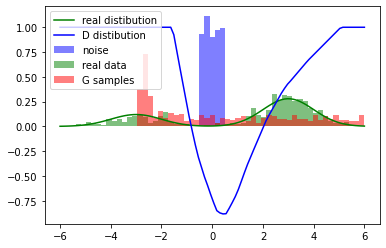

Epoch 18/50 (25s): G=1.120, Dr=1.144, Df=1.102 WD=0.000, GP=0.327


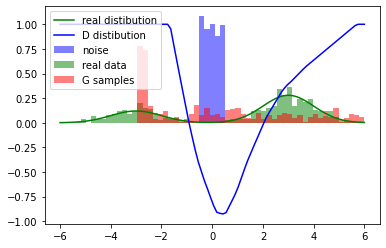

Epoch 19/50 (26s): G=1.037, Dr=1.067, Df=1.028 WD=0.003, GP=0.329


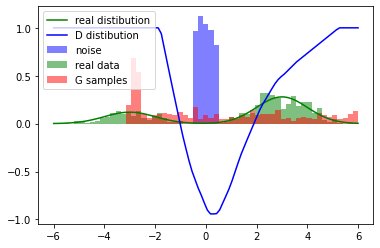

Epoch 20/50 (28s): G=0.978, Dr=1.010, Df=0.983 WD=-0.003, GP=0.333


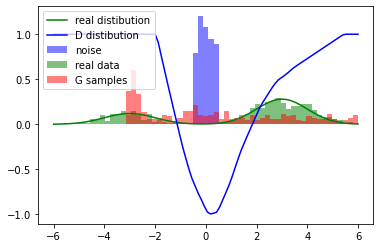

Epoch 21/50 (30s): G=0.942, Dr=0.986, Df=0.949 WD=0.002, GP=0.325


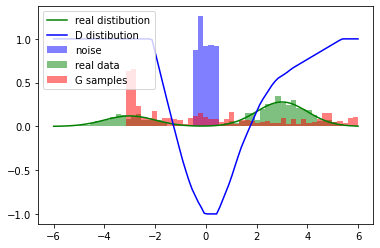

Epoch 22/50 (31s): G=0.823, Dr=0.910, Df=0.866 WD=-0.000, GP=0.341


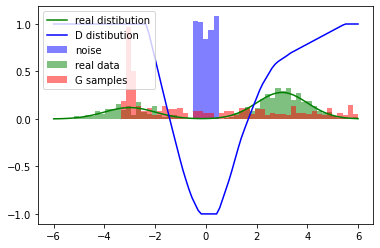

Epoch 23/50 (33s): G=0.755, Dr=0.849, Df=0.764 WD=0.000, GP=0.365


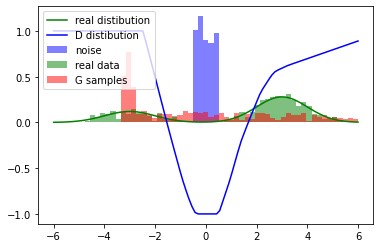

Epoch 24/50 (34s): G=0.658, Dr=0.772, Df=0.668 WD=0.001, GP=0.388


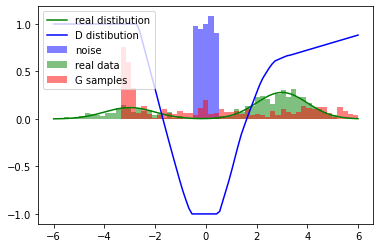

Epoch 25/50 (35s): G=0.558, Dr=0.714, Df=0.592 WD=0.002, GP=0.404


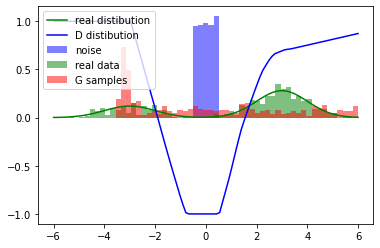

Epoch 26/50 (37s): G=0.525, Dr=0.686, Df=0.538 WD=0.001, GP=0.410


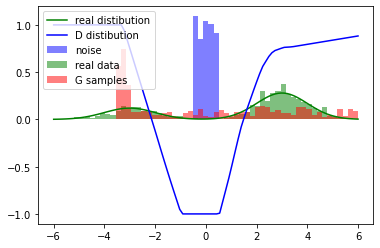

Epoch 27/50 (38s): G=0.468, Dr=0.655, Df=0.459 WD=0.003, GP=0.421


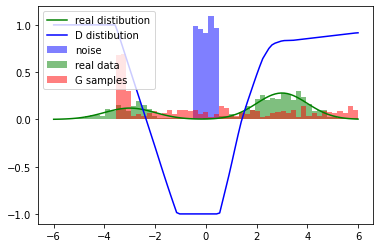

Epoch 28/50 (40s): G=-0.122, Dr=0.248, Df=-0.099 WD=0.005, GP=0.393


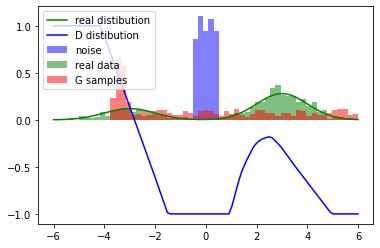

Epoch 29/50 (41s): G=-1.205, Dr=-0.659, Df=-1.231 WD=0.006, GP=0.268


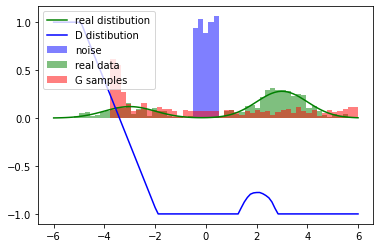

Epoch 30/50 (42s): G=-1.719, Dr=-1.155, Df=-1.649 WD=0.003, GP=0.232


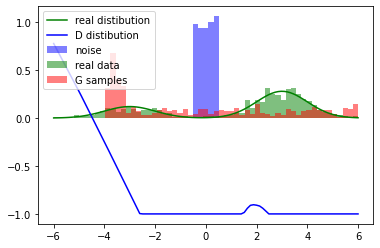

Epoch 31/50 (44s): G=-1.740, Dr=-1.342, Df=-1.773 WD=0.006, GP=0.249


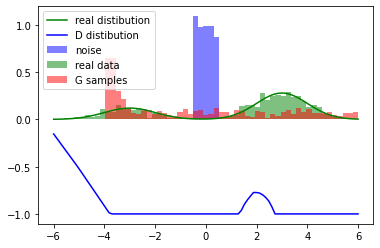

Epoch 32/50 (45s): G=-1.743, Dr=-1.295, Df=-1.758 WD=0.007, GP=0.303


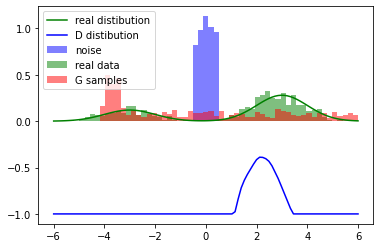

Epoch 33/50 (47s): G=-1.704, Dr=-1.067, Df=-1.707 WD=0.009, GP=0.364


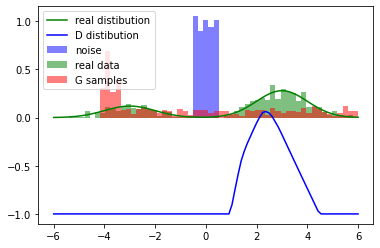

Epoch 34/50 (48s): G=-1.699, Dr=-0.816, Df=-1.678 WD=0.008, GP=0.437


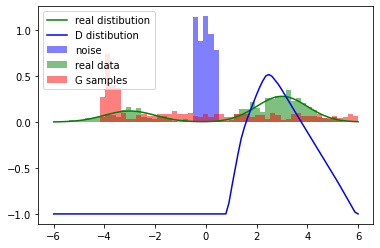

Epoch 35/50 (50s): G=-2.019, Dr=-0.792, Df=-1.948 WD=0.015, GP=0.424


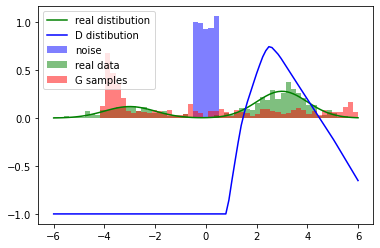

Epoch 36/50 (51s): G=-2.648, Dr=-1.158, Df=-2.591 WD=0.024, GP=0.274


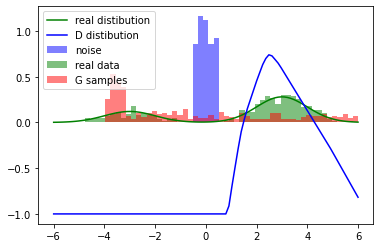

Epoch 37/50 (53s): G=-3.068, Dr=-1.550, Df=-3.038 WD=0.017, GP=0.225


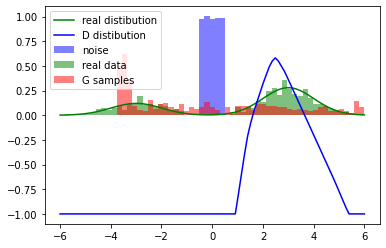

Epoch 38/50 (55s): G=-3.368, Dr=-1.946, Df=-3.336 WD=0.011, GP=0.187


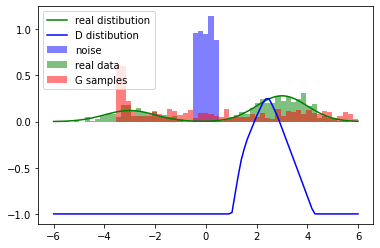

Epoch 39/50 (56s): G=-3.660, Dr=-2.398, Df=-3.722 WD=0.019, GP=0.153


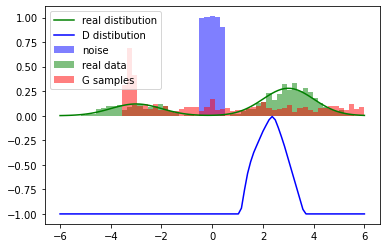

Epoch 40/50 (58s): G=-3.931, Dr=-2.620, Df=-3.930 WD=0.014, GP=0.147


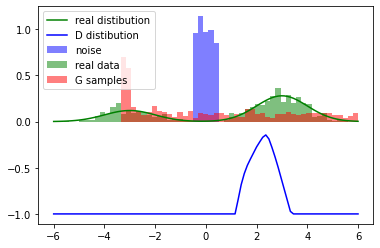

Epoch 41/50 (59s): G=-3.893, Dr=-2.765, Df=-3.947 WD=0.009, GP=0.150


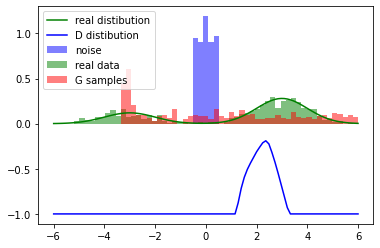

Epoch 42/50 (61s): G=-3.846, Dr=-2.747, Df=-3.929 WD=0.009, GP=0.160


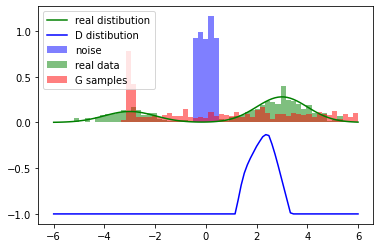

Epoch 43/50 (62s): G=-3.692, Dr=-2.661, Df=-3.731 WD=0.010, GP=0.172


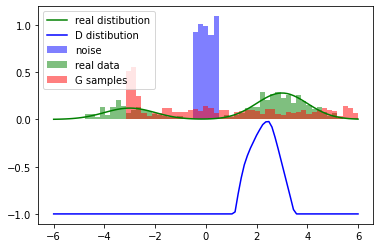

Epoch 44/50 (64s): G=-3.586, Dr=-2.588, Df=-3.532 WD=0.004, GP=0.175


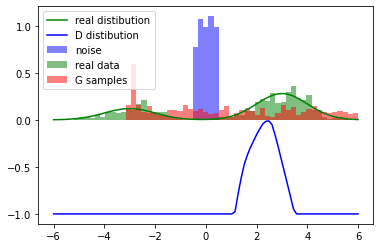

Epoch 45/50 (66s): G=-3.312, Dr=-2.420, Df=-3.382 WD=0.012, GP=0.179


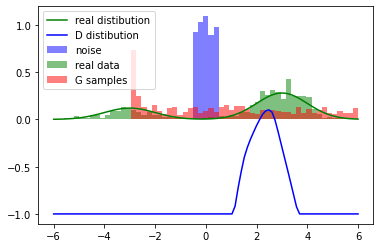

Epoch 46/50 (67s): G=-3.199, Dr=-2.291, Df=-3.159 WD=0.009, GP=0.190


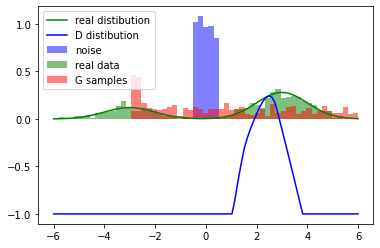

Epoch 47/50 (68s): G=-2.822, Dr=-2.138, Df=-2.899 WD=0.013, GP=0.192


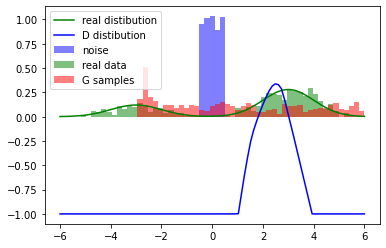

Epoch 48/50 (69s): G=-2.699, Dr=-2.013, Df=-2.708 WD=0.012, GP=0.197


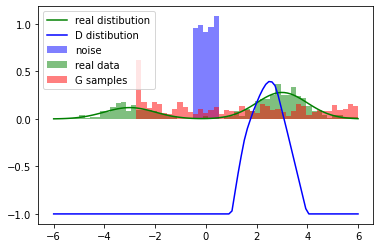

Epoch 49/50 (71s): G=-2.538, Dr=-1.861, Df=-2.548 WD=0.008, GP=0.205


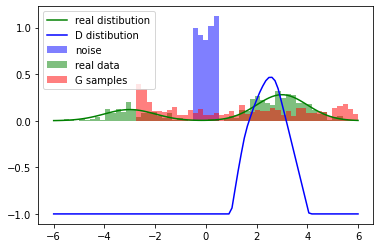

Epoch 50/50 (72s): G=-2.368, Dr=-1.693, Df=-2.332 WD=0.004, GP=0.221


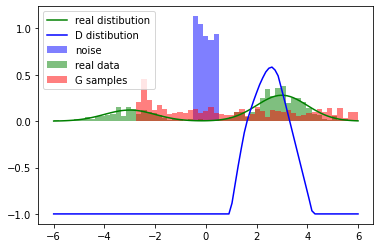

In [88]:
step_size = 30
loss_g, loss_d_real, loss_d_fake, loss_WD, loss_gp = [], [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running, loss_gp_running = 0, 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_, lgp_) = gan.train_step()
        #ldr_, ldf_ = gan.train_step_D()
        #if i%step_size == 0:
        #    print(i)
        #    print('D train step')
        #    visualize_GAN(gan)
        #lg_ = gan.train_step_G()
        #if i%step_size == 0:
        #    print('G train step')
        #    visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_gp_running += lgp_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_gp.append(loss_gp_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}"
          f" WD={loss_WD[-1]:.3f},"
          f" GP={loss_gp[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break